In [2]:
import sys
import time
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader
from hyper_rbm import SymmetricHyperRBM, train_loop, get_sigmoid_curve
from wavefunction_overlap import generate_basis_states, calculate_exact_overlap, load_gt_wavefunction


data_dir = Path("measurements")
state_dir = Path("state_vectors")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")

Running on: cpu


In [3]:
def train_experiment_model(file_paths: List[Path], n_samples: int, config: Dict[str, Any],
                           rng: torch.Generator, device: torch.device) -> SymmetricHyperRBM:

    dataset = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [n_samples] * len(file_paths))
    loader = MeasurementLoader(dataset, batch_size=config["batch_size"], shuffle=True, drop_last=False, rng=rng)

    model = SymmetricHyperRBM(num_v=dataset.num_qubits, num_h=config["num_hidden"],
                              hyper_dim=config["hyper_dim"], k=config["k_steps"]).to(device)
    model.initialize_weights(std=config["init_std"])

    optimizer = torch.optim.Adam(model.parameters(), lr=config["init_lr"])

    steps = config["epochs"] * len(loader)
    scheduler = get_sigmoid_curve(config["init_lr"], config["final_lr"], steps, 0.005)

    model = train_loop(model, optimizer,  loader, num_epochs=config["epochs"],
                       lr_schedule_fn=scheduler, noise_frac=config["gibbs_noise"], rng=rng)

    return model


def evaluate_overlap_sweep(model: SymmetricHyperRBM, h_values: List[float],
                           gt_wavefunctions: Dict[float, torch.Tensor], basis_states: torch.Tensor) -> List[float]:
    overlaps = []
    for h in h_values:
        psi_true = gt_wavefunctions[h]
        ov = calculate_exact_overlap(model, h, psi_true, basis_states)
        overlaps.append(ov)

    return overlaps

In [4]:
SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 20_000

# FIXED SAMPLE SIZE
N_SAMPLES = 2_000

H_TRAIN = [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00]
H_EVAL = [1.50, 2.50, 2.80, 3.20, 3.50, 4.50, 5.50, 6.50]
ALL_H = sorted(list(set(H_TRAIN + H_EVAL)))

SEED = 42
torch.manual_seed(SEED)

# Map H values to file paths
file_map = {h: data_dir / f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz"
            for h in H_TRAIN}
all_file_paths = [file_map[h] for h in H_TRAIN]

print("Pre-loading ground truth wavefunctions...")
all_states = generate_basis_states(SIDE_LENGTH**2, device)
gt_map = {}

for h_val in ALL_H:
    gt_path = state_dir / f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h_val:.2f}.npz"
    gt_map[h_val] = load_gt_wavefunction(gt_path, device)

print(f"Loaded {len(gt_map)} GT states.")

Pre-loading ground truth wavefunctions...
Loaded 15 GT states.


In [5]:
TRAIN_CONFIG = {
    "epochs": 50,
    "batch_size": 1024,
    "num_hidden": 64,
    "hyper_dim": 64,
    "k_steps": 10,
    "init_lr": 1e-2,
    "final_lr": 1e-4,
    "gibbs_noise": 0.1,
    "init_std": 0.05
}

torch.manual_seed(SEED)
rng = torch.Generator().manual_seed(SEED)

# --- 1. Train Joint Hyper-RBM (All Data) ---
print(f"\n### TRAINING JOINT HYPER-MODEL (Samples per point: {N_SAMPLES}) ###")
hyper_model = train_experiment_model(all_file_paths, N_SAMPLES, TRAIN_CONFIG, rng, device)

# Evaluate Joint model on ALL H values (interpolation capability)
print("Evaluating Joint Model...")
hyper_overlaps = evaluate_overlap_sweep(hyper_model, ALL_H, gt_map, all_states)

# Store results
df_hyper = pd.DataFrame({"h": ALL_H, "overlap": hyper_overlaps})
df_hyper["type"] = df_hyper["h"].apply(lambda x: "support" if any(np.isclose(x, s) for s in H_TRAIN) else "novel")

# --- 2. Train Single RBMs (One per Support Point) ---
single_overlaps = []
print(f"\n### TRAINING SINGLE MODELS (Samples: {N_SAMPLES}) ###")

for h_val in H_TRAIN:
    print(f"  > Training individual model for h={h_val:.2f}...")

    # Train on ONLY this specific file
    specific_path = [file_map[h_val]]

    # We use a fresh seed or the same generator to ensure comparable weight initialization stochasticity
    single_model = train_experiment_model(specific_path, N_SAMPLES, TRAIN_CONFIG, rng, device)

    # Evaluate ONLY at this specific h
    psi_true = gt_map[h_val]
    ov = calculate_exact_overlap(single_model, h_val, psi_true, all_states)
    single_overlaps.append(ov)

df_single = pd.DataFrame({"h": H_TRAIN, "overlap": single_overlaps})

print("\nAll experiments finished.")
print(f"Mean Joint Overlap (Supports): {df_hyper[df_hyper['type']=='support']['overlap'].mean():.5f}")
print(f"Mean Single Overlap (Supports): {df_single['overlap'].mean():.5f}")


### TRAINING JOINT HYPER-MODEL (Samples per point: 2000) ###
Epoch  | Loss       | LR        
-----------------------------------
1      | -0.0829     | 0.008451
10     | +0.0190     | 0.007443
20     | +0.0094     | 0.005920
30     | +0.0033     | 0.004204
40     | -0.0324     | 0.002676
50     | -0.0157     | 0.001572
Evaluating Joint Model...

### TRAINING SINGLE MODELS (Samples: 2000) ###
  > Training individual model for h=1.00...
Epoch  | Loss       | LR        
-----------------------------------
1      | -0.7664     | 0.005653
10     | +1.2959     | 0.005433
20     | +0.5806     | 0.005186
30     | -0.2449     | 0.004939
40     | +0.0995     | 0.004692
50     | -0.0349     | 0.004447
  > Training individual model for h=2.00...
Epoch  | Loss       | LR        
-----------------------------------
1      | -0.4250     | 0.005653
10     | +1.1580     | 0.005433
20     | +0.2507     | 0.005186
30     | -0.0415     | 0.004939
40     | -0.0236     | 0.004692
50     | -0.0513     | 0.

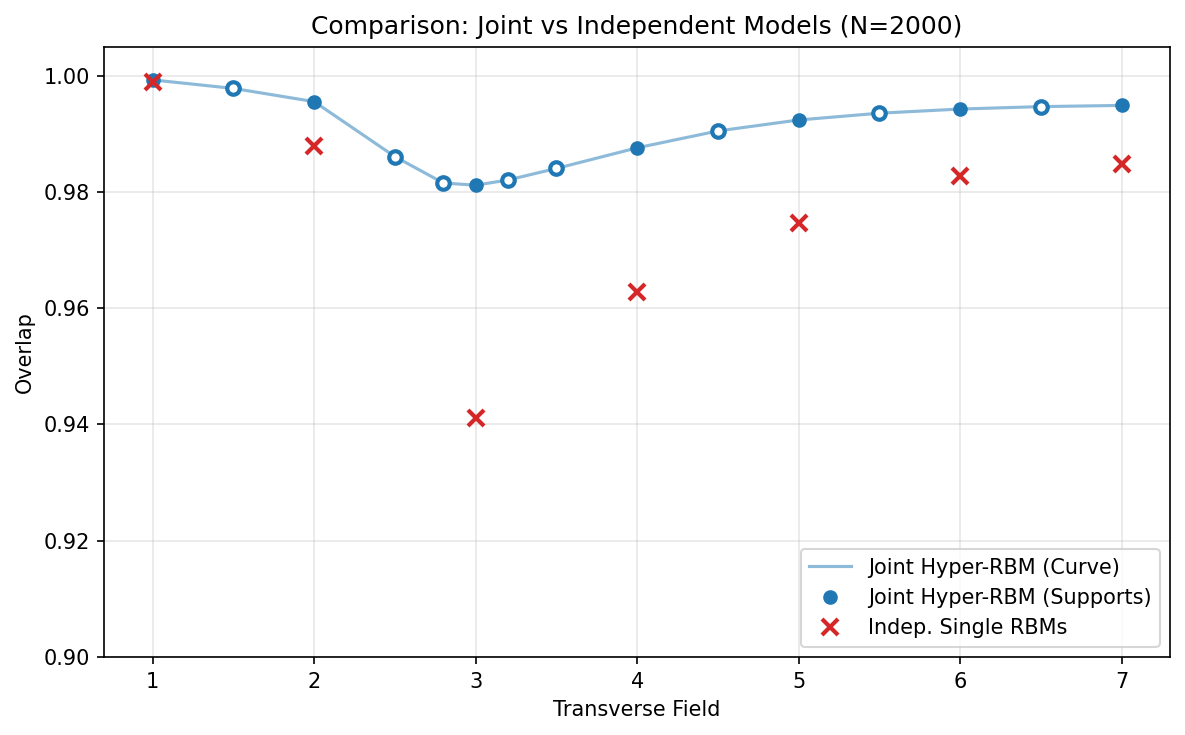

In [7]:
plt.figure(figsize=(8, 5), dpi=150)

# Extract subsets for the Joint Hyper Model
hyper_support = df_hyper[df_hyper["type"] == "support"]
hyper_novel = df_hyper[df_hyper["type"] == "novel"]

# 1. Plot the Joint Hyper Model (Curve + Points)
plt.plot(df_hyper["h"], df_hyper["overlap"], '-', color="C0", alpha=0.5, label="Joint Hyper-RBM (Curve)")
plt.plot(hyper_support["h"], hyper_support["overlap"], 'o', color="C0", label="Joint Hyper-RBM (Supports)")
plt.plot(hyper_novel["h"], hyper_novel["overlap"], 'o', color="C0", mfc='white', mew=2, markersize=6)

# 2. Plot the Single Independent Models
plt.plot(df_single["h"], df_single["overlap"], 'x', color="C3", markeredgewidth=2, markersize=8, label="Indep. Single RBMs")

plt.xlabel("Transverse Field")
plt.ylabel("Overlap")
plt.title(f"Comparison: Joint vs Independent Models (N={N_SAMPLES})")
plt.ylim(0.90, 1.005)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()